In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves')

In [ ]:
from help_funcs import * 
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import gsw

import pandas as pd
import xarray as xr
import numpy as np
import netCDF4 as nc

import cmocean.cm as cm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

from multiprocessing import Pool
import multiprocessing
from os.path import exists
from pathlib import Path
from natsort import natsorted
import importlib

In [ ]:
sns.set_context("notebook")

In [22]:
%%time
GLORYS_dir = r"/vortexfs1/home/anthony.meza/GLORYS_data" 
results = [str(result) for result in list(Path(GLORYS_dir).rglob("*.[nN][cC]"))] #get all files
results = natsorted(results) #sort all files 

years = natsorted(list(set([result[41:45] for result in results])))
months = natsorted(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

CPU times: user 232 ms, sys: 42.8 ms, total: 275 ms
Wall time: 275 ms


In [23]:
def remove_seasonal(ds):
    climatology = ds.groupby("time.month").mean("time")
    anomalies = ds.groupby("time.month") - climatology
    return anomalies.drop("month")

def timecat(fnames):
    datasets = xr.concat(fnames, dim = "time", data_vars = "minimal", coords = "minimal")
    datasets = datasets.sortby("time")
    return datasets

def read_subset(years, read_atm):
    n_cores = multiprocessing.cpu_count() - 5
    file_path = "ERA5_data"
    ERA5_results = natsorted([str(result) for result in list(Path(file_path).rglob("*.[nN][cC]"))])[:-1]
    files = natsorted([str(f) for f in ERA5_results if f[-7:-3] in years])
        
    dsets = []
    if __name__ == '__main__':
        with Pool(n_cores) as p:
            datasets = p.map(read_atm, files)
    datasets = [d for d in datasets]
    dsets = dsets + datasets #about 50 gigs of data!! 
    
    return dsets

In [79]:
def plot_spatial_var(ax, data, LONS, LATS, bounds, levels):
    cf = ax.contourf(LONS, LATS, data, 
                      vmin = -bounds, vmax = bounds, levels = levels, 
                      cmap=cm.curl, extend = "both")
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.0)
    gl.top_labels = False
    gl.right_labels = False
    return cf 

def animate_spatial_var(da, NINO_idx, event_name):

    fig,ax1 = plt.subplots(figsize = (5, 5),  subplot_kw = {"projection":ccrs.PlateCarree()})

    data = da.values
    times = da.time.values
    times = pd.to_datetime(times).strftime('%Y-%m-%d')
    nt = len(times)


    LONS, LATS = np.meshgrid(da.longitude, da.latitude)
    bounds = np.nanmax(np.abs(data))
    levels = np.linspace(-bounds, bounds, 21)

    cf = plot_spatial_var(ax1, data[0, :, :], LONS, LATS, bounds, levels)

    fig.colorbar(cf, ax = ax1, fraction = 0.03, orientation = "vertical")
    fig.suptitle("Total Precipitation Anomalies \n (Seasonal Cycle Removed)")
    fig.tight_layout()
    
    
    def animate(i):
        ax1.clear(); 
        fontweight = "normal" if NINO_idx.values[i] < 0.5 else "bold"
        ax1.set_title(times[i] + "; NIÑO 3.4 = " + str(NINO_idx.values[i]), fontweight = fontweight)
        plot_spatial_var(ax1, data[i, :, :], LONS, LATS, bounds, levels)
        # ax1.plot(xs_C, ys_C, color = "k")
    anim = FuncAnimation(fig, animate, frames=nt, interval=20, blit=False)
    anim.save(event_name + '.mp4', writer='ffmpeg')
    print("Saving Animation")

### Get NINO 3.4 Index

In [80]:
df = pd.read_csv("nino34.long.csv", index_col=0)
dates_df = df.astype("datetime64[D]")

for year in range(0, len(df.index)):
    for month in range(1, len(df.columns)+1):
        dates_df.iloc[year, month - 1] = np.datetime64(pd.Timestamp(df.index[year], month, 15), "D")
NINO34_ds = xr.DataArray(
            data=df.values.flatten(),
            dims=["time"],
            coords=dict(time=dates_df.values.flatten()))
NINO34 = NINO34_ds.sel(time = slice("1993", None))

### Make some anomaly movies 

In [81]:
def read_ds_atm(fname): #very little memory footprint, 1 day = 500kib
    with xr.open_dataset(fname) as ds:
        ds_new = ds.sel(longitude = slice(-121, -115), latitude = slice(35, 30))
        return ds_new

In [82]:
%%time 
all_years = [["1997", "1998", "1999"], ["2001", "2002", "2003"],
             ["2005", "2006", "2007"], ["2008", "2009", "2010"],
             ["2014", "2015", "2016"]]

all_slices = [slice("1997", "1999.4"), slice("2001.5", "2003"),
              slice("2005.5", "2007"), slice("2008.7", "2010"),
              slice("2014", "2016")]

all_events = ["97NinoTP", "02NinoTP", 
              "06NinoTP", "09NinoTP", 
              "15NinoTP"]
nevents = len(all_events)

CPU times: user 6 µs, sys: 4 µs, total: 10 µs
Wall time: 13.4 µs


In [83]:
def animate_years(yrs, time_slice, event_name, smooth = False):
    NINO = read_subset(years, read_ds_atm)
    NINO_ds = timecat(NINO)

    tp_NINO = NINO_ds.tp
    tp_NINO = tp_NINO.resample(time="1D").mean() #resample from 1 hr to 1 day
    if smooth:
        tp_NINO = tp_NINO.rolling(time=21, center=True).mean() #21-day rolling average
        event_name = event_name + "Smooth"
        
    tp_NINO = 1e3 * 24 * tp_NINO
    tp_NINO = remove_seasonal(tp_NINO).sel(time = time_slice)

    #get 
    NINO34_sub = remove_seasonal(NINO34).interp(time = tp_NINO.time).sel(time = time_slice)
    NINO34_sub = np.round(NINO34_sub, decimals = 2)
    #animate
    animate_spatial_var(tp_NINO, NINO34_sub, event_name)

97NinoTP
Saving Animation


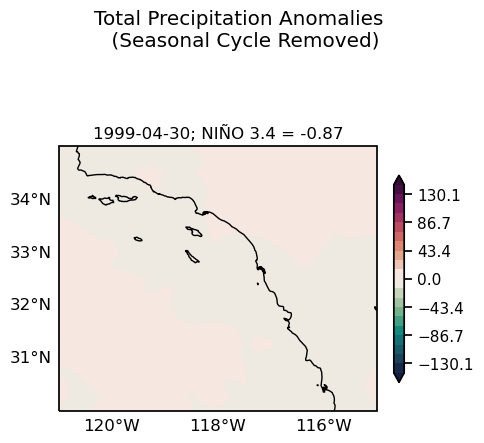

In [84]:
for i in range(0, nevents):
    yrs = all_years[i]; time_slice=all_slices[i]; event_name = all_events[i]
    print(event_name)
    #read in years
    animate_years(yrs, time_slice, event_name, True)

97NinoTP
Saving Animation
02NinoTP
Saving Animation
06NinoTP
Saving Animation
09NinoTP
Saving Animation
15NinoTP
Saving Animation


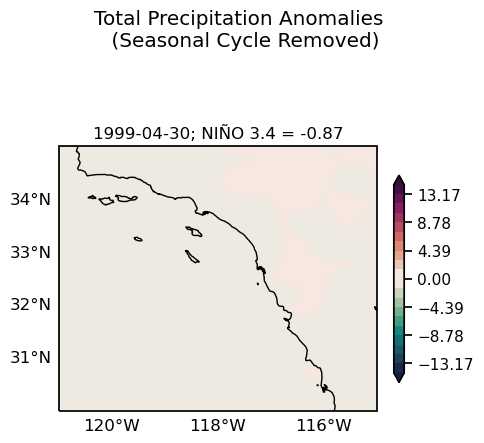

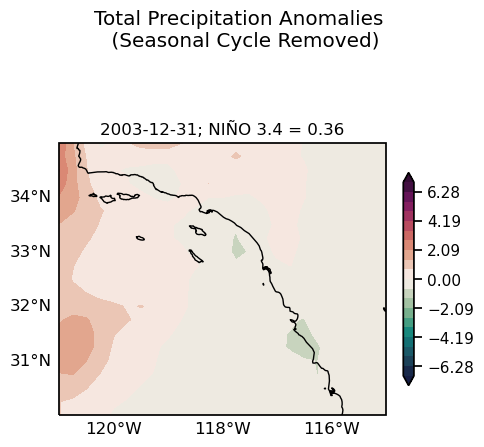

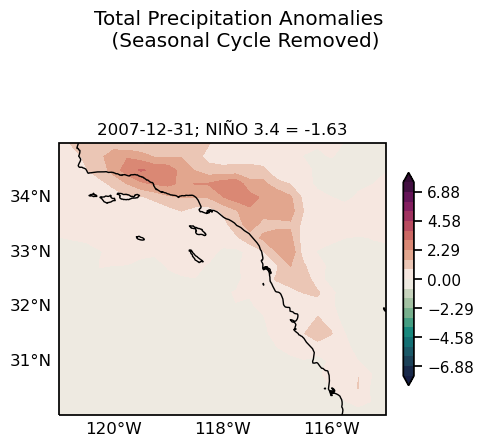

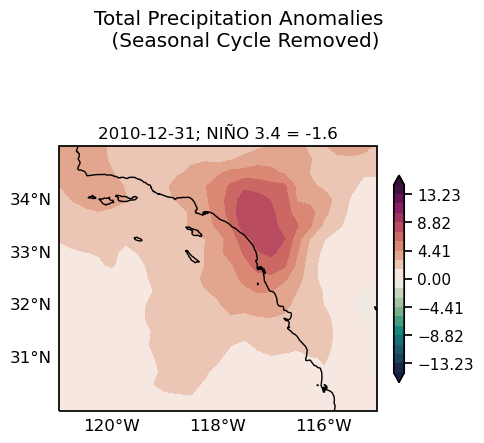

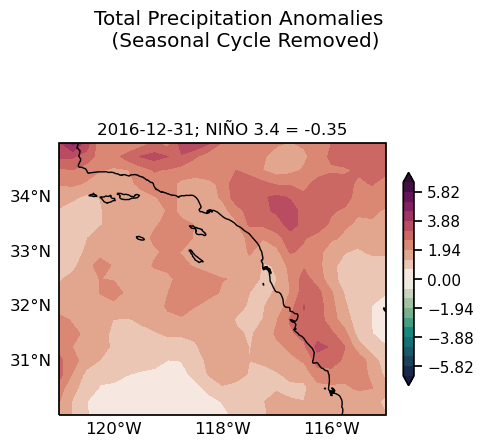

In [85]:
for i in range(0, nevents):
    yrs = all_years[i]; time_slice=all_slices[i]; event_name = all_events[i]
    print(event_name)
    #read in years
    animate_years(yrs, time_slice, event_name, True)